# References
https://spinningup.openai.com/en/latest/algorithms/sac.html

# Import

In [1]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import pickle

from stable_baselines3.common.buffers import ReplayBuffer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Params

In [2]:
ENV_ARGS = {
    'id': "Hopper-v4"
}
NUM_ENVS = 3
SEED = 1

LR = 1e-4
NUM_STEPS = 2048
NUM_ITERATIONS = 1000
GAMMA = 0.99
GAE_LAMBDA = 0.95
UPDATE_EPOCHS = 10
CLIP_COEF = 0.2 # the epsilon in KL divergece in PPO paper
ENTROPY_COEF = 0.0
VF_COEF = 0.5
MAX_GRAD_NORM = 0.5
MINI_BATCH_COUNT = 32
UPDATE_PLOTS = 10

LOG_STD_MAX = 2
LOG_STD_MIN = -5

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
#output directory
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output', ENV_ARGS['id'])

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

#seeding
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.set_default_dtype(torch.float32)
torch.set_default_tensor_type(torch.FloatTensor)

# Env

In [3]:
def make_env(gamma, **env_args):
    env = gym.make(**env_args)
    # env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    # env = gym.wrappers.ClipAction(env)
    # env = gym.wrappers.NormalizeObservation(env)
    # env = gym.wrappers.TransformObservation(env, lambda obs: np.clip(obs, -10, 10))
    # env = gym.wrappers.NormalizeReward(env, gamma = gamma)
    # env = gym.wrappers.TransformReward(env, lambda reward: np.clip(reward, -10, 10))
    return env


In [4]:
# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(gamma= 0.99, **ENV_ARGS) for _ in range(NUM_ENVS)]
) 

#check to make sure this is continous action
assert isinstance(envs.single_action_space, gym.spaces.Box), 'Only continous action is supported'

# Model

In [5]:
def layer_init(layer: nn.Linear, std = np.sqrt(2), bias_const = 0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class QNetwork(nn.Module):
    def __init__(self,envs: gym.Env, hidden_size = 256):
        super().__init__()

        self.state_shape = np.prod(envs.single_observation_space.shape)
        self.action_shape = np.prod(envs.single_action_space.shape)

        self.network = nn.Sequential(
            layer_init(nn.Linear(self.state_shape + self.action_shape, hidden_size)),
            nn.ReLU(),
            layer_init(nn.Linear(hidden_size, hidden_size)),
            nn.ReLU(),
            layer_init(nn.Linear(hidden_size, 1)),
        )
    
    def forward(self, state, action):
        x = torch.cat((state, action), dim = 1)
        return self.network(x)

class Actor(nn.Module):

    def __init__(self, envs: gym.Env, hidden_size = 256):
        super().__init__()

        self.state_shape = np.prod(envs.single_observation_space.shape)
        self.action_shape = np.prod(envs.single_action_space.shape)

        self.network = nn.Sequential(
            layer_init(nn.Linear(self.state_shape, hidden_size)),
            nn.ReLU(),
            layer_init(nn.Linear(hidden_size, hidden_size)),
            nn.ReLU(),
        )

        self.fc_mean = nn.Linear(hidden_size, self.action_shape)
        self.fc_logstd = nn.Linear(hidden_size, self.action_shape)

        #NOTE: register buffer so that optimizer will not update its values
        self.register_buffer(
            "action_scale", torch.tensor((envs.single_action_space.high - envs.single_action_space.low)/2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((envs.single_action_space.high + envs.single_action_space.low)/2.0, dtype=torch.float32)
        )
    
    def forward(self, X):
        X = self.network(X)
        mean = self.fc_mean(X)
        logstd = torch.tanh(self.fc_logstd(X))
        # https://spinningup.openai.com/en/latest/algorithms/sac.html
        logstd = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (logstd + 1)

        return mean, logstd
    
    def get_action(self, X):

        mean, logstd = self(X)
        #exponential to convert from log(std) to std
        std = logstd.exp()

        normal = torch.distributions.Normal(mean, std)
        #reparameterize trick 
        # https://stackoverflow.com/questions/60533150/what-is-the-difference-between-sample-and-rsample
        x_t = normal.rsample()
        y_t = torch.tanh(x_t)

        #action scale and bias is registered as buffer in init()
        # print('y t shape = ', y_t.shape)
        # print('scale shape = ', self.action_scale.shape)
        # print('bias shape = ', self.action_bias.shape)

        action = y_t * self.action_scale + self.action_bias

        logprob = normal.log_prob(x_t)

        logprob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        logprob = logprob.sum(1, keepdim = True)

        mean = torch.tanh(mean) * self.action_scale + self.action_bias

        return action, logprob, mean



In [6]:
#Test agent
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(gamma= 0.99, **ENV_ARGS) for _ in range(NUM_ENVS)]
) 
obs, info = envs.reset()

actor = Actor(envs)
qnet = QNetwork(envs)

obs = torch.tensor(obs).float()
action = torch.tensor(envs.action_space.sample()).float()
print('state shape = ', obs.shape)
print('action shape = ', action.shape)

qvalue = qnet(obs, action)
print('q value = ', qvalue.shape)

actor_action, logprob, mean = actor.get_action(obs)
print('actor action = ', actor_action.shape)
print('logprob  = ', logprob.shape)
print('mean  = ', mean.shape)


# action, log_prob, entropy, value = test_agent.get_action_and_value(obs)

# print('log prob shape = ', log_prob.shape)
# print('entropy shape = ', entropy.shape)
# print('value shape = ', value.shape)

# del test_agent

envs.close()

state shape =  torch.Size([3, 11])
action shape =  torch.Size([3, 3])
q value =  torch.Size([3, 1])
actor action =  torch.Size([3, 3])
logprob  =  torch.Size([3, 1])
mean  =  torch.Size([3, 3])


# Utils

In [7]:
def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()
        
    plt.clf()
    plt.close()

def replay_buffer_usage(rb: ReplayBuffer):
    return (rb.pos / rb.buffer_size) * 100 if rb.full == False else 100

def pickle_dump(obj, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)
    
def pickle_load(path):
    with open(path, 'rb') as file:
        obj = pickle.dump(file)
    return obj

def evaluate(agent, episodes = 10):
    envs = gym.vector.SyncVectorEnv([lambda: make_env(gamma = GAMMA, **ENV_ARGS)])
    agent.eval()
    total_rewards = []
    next_obs, _ = envs.reset()

    while len(total_rewards) < episodes: 
        next_obs = torch.Tensor(next_obs)
        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)

        next_obs, reward, terminated, truncated, info = envs.step(action.numpy())

        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r'][0]
                    total_rewards.append(reward)

    return total_rewards


def soft_update(net:nn.Module, other: nn.Module, tau = 0.005):
    for this_param, other_param in zip(net.parameters(), other.parameters()):
        this_param.data.copy_(tau * other_param.data + (1 - tau) * this_param.data)
    
def weight_update(net:nn.Module, other: nn.Module, tau = 0.005):
    net.load_state_dict(other.state_dict())


# Training

In [50]:
def tune(
    envs: gym.Env, actor:Actor, qf1:QNetwork, qf2:QNetwork, 
    qf1_target:QNetwork, qf2_target:QNetwork,
    q_optimizer, actor_optimizer, device,
    buffer_size = int(1e6), batch_size = 32,
    total_timesteps = 1000, warmup_steps = 50,
    policy_update_freq = 2, target_net_update_freq = 1, gamma = 0.99, 
    plot_update_freq = 10, label = 'test', plot_udpate_freq = 10, history = None):

    SAVE_PATH = os.path.join(OUTPUT, label)
    FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')
    HISTORY_PATH = os.path.join(SAVE_PATH, 'history.pickle')

    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    print('save path = ', SAVE_PATH)

    state_size = np.prod(envs.single_observation_space.shape)
    action_size = np.prod(envs.single_action_space.shape)
    n_envs = envs.observation_space.shape[0]

    #default to float
    envs.single_observation_space.dtype = np.float32

    alpha = 0.2 # expected return and entropy trade-off coefficient 

    # target_entropy = -torch.prod(torch.Tensor(envs.single_action_space.shape).to(device)).item()
    # log_alpha = torch.zeros(1, requires_grad = True, device= device)
    # alpha = log_alpha.exp().item()
    # a_optimizer = torch.optim.Adam([log_alpha], lr = 1e-3)

    replay_buffer = ReplayBuffer(
            buffer_size,
            envs.single_observation_space, 
            envs.single_action_space, 
            device = device,
            handle_timeout_termination=False,
            optimize_memory_usage=True,
            n_envs=n_envs
    )

    obs, _ = envs.reset()
    avg_reward = 0
    avg_reward = 0
    best_score = -float('inf')
    score_window = deque(maxlen = 100)
    if history == None:
        history = defaultdict(list)

    loop = tqdm(range(total_timesteps))
    episode_count = 0
    updated_t = 0

    #start training loop
    for global_step in loop:
        t = int(loop.format_dict['elapsed'])

        #if still warming up, get random action
        if global_step < warmup_steps:
            actions = envs.action_space.sample()
        
        #else done warmup, get actions from actor
        else:
            actions, _,_ = actor.get_action(torch.tensor(obs).to(device).float())
            actions = actions.detach().cpu().numpy()
        
        next_obs, rewards, terminations, truncations, infos = envs.step(actions)

        if 'final_info' in infos:
            for info in infos['final_info']:
                if info and 'episode' in info:
                    test = True
                    ep_return = info['episode']['r']
                    score_window.append(ep_return)
                    episode_count += 1

                    avg_reward = np.mean(score_window)
                    history['reward'].append(avg_reward)
                    history['buffer_usage'].append(replay_buffer_usage(replay_buffer))

                    #save model with new best score 
                    if avg_reward > best_score:
                        best_score = avg_reward
                        torch.save(actor, os.path.join(SAVE_PATH, 'actor.checkpoint.torch'))
                        torch.save(qf1, os.path.join(SAVE_PATH, 'qf1.checkpoint.torch'))
                        torch.save(qf2, os.path.join(SAVE_PATH, 'qf2.checkpoint.torch'))
                        torch.save(qf1_target, os.path.join(SAVE_PATH, 'qf1_target.checkpoint.torch'))
                        torch.save(qf2_target, os.path.join(SAVE_PATH, 'qf2_target.checkpoint.torch'))

        real_next_obs = next_obs.copy()
        for i, truncated in enumerate(truncations):
            if truncated:
                real_next_obs[i] = infos['final_observation'][i]
        
        replay_buffer.add(obs, real_next_obs, actions, rewards, terminations, infos)

        obs = next_obs

        #optimize when done warming up 
        if global_step > warmup_steps:

            data = replay_buffer.sample(batch_size)
            b_next_obs = data.next_observations.to()
            b_obs = data.observations
            b_actions = data.actions
            b_rewards = data.rewards
            b_dones = data.dones

            with torch.no_grad():
                next_state_actions, next_state_log_probs, _ = actor.get_action(b_next_obs)
                qf1_next_target = qf1_target(b_next_obs, next_state_actions)
                qf2_next_target = qf2_target(b_next_obs, next_state_actions)
                min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - alpha * next_state_log_probs
                next_q_value = b_rewards.flatten() + (1 - b_dones.flatten()) * gamma * min_qf_next_target.view(-1)
            
            qf1_a_values = qf1(b_obs, b_actions).view(-1)
            qf2_a_values = qf2(b_obs, b_actions).view(-1)

            qf1_loss = F.mse_loss(qf1_a_values, next_q_value)
            qf2_loss = F.mse_loss(qf2_a_values, next_q_value)

            qf_loss = qf1_loss + qf2_loss

            #step q_optimizer
            q_optimizer.zero_grad()
            qf_loss.backward()
            q_optimizer.step()

            #TD3 update delayed
            if global_step % policy_update_freq == 0:
                for _ in range(policy_update_freq):

                    pi, log_pi, _ = actor.get_action(b_obs)

                    qf1_pi = qf1(b_obs, pi)
                    qf2_pi = qf2(b_obs, pi)

                    min_qf_pi = torch.min(qf1_pi, qf2_pi)

                    actor_loss = ((alpha * log_pi) - min_qf_pi).mean()

                    actor_optimizer.zero_grad()
                    actor_loss.backward()
                    actor_optimizer.step()

                    # with torch.no_grad():
                    #     _, log_pi,_ = actor.get_action(b_obs)

                    # alpha_loss = (-log_alpha.exp() * (log_pi + target_entropy)).mean()

                    # a_optimizer.zero_grad()
                    # alpha_loss.backward()
                    # a_optimizer.step()

                    # alpha = log_alpha.exp().item()
            
            if global_step % target_net_update_freq == 0:
                soft_update(qf1_target, qf1)
                soft_update(qf2_target, qf2)
        
        if t != updated_t and t % plot_update_freq == 0: 
            updated_t = t
            loop.set_description(f"avg_reward = {avg_reward:.2f}, best_score = {best_score}, episode_count = {episode_count}, buffer usage = {replay_buffer_usage(replay_buffer):.2f}")
            plot(history, save_path = FIG_SAVE_PATH)
            pickle_dump(history, HISTORY_PATH)

    plot(history, show = True, save_path = FIG_SAVE_PATH)
    envs.reset()




save path =  /Volumes/SanDisk/NLP_RNN/Reinforcement Learning/deep rl/final_project/sac/output/Hopper-v4/baseline


avg_reward = 2723.62, best_score = 3246.17431640625, episode_count = 2887, buffer usage = 100.00: 100%|██████████| 500000/500000 [1:44:38<00:00, 79.64it/s]   


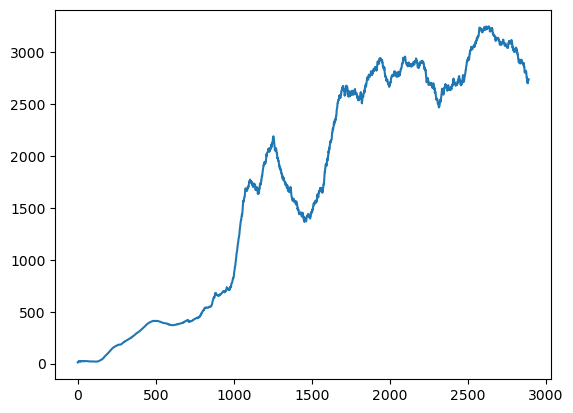

In [51]:
device= DEVICE
q_lr = 1e-3
actor_lr = 1e-3
total_timesteps = int(5e5)
warmup_steps = int(1e3)
buffer_size = int(5e5)
batch_size = 256
fc_hidden_size = 256

# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(gamma= 0.99, **ENV_ARGS) for _ in range(NUM_ENVS)]
) 
assert isinstance(envs.single_action_space, gym.spaces.Box), 'Only continous action is supported'

actor = Actor(envs, hidden_size=fc_hidden_size).to(device)
qf1 = QNetwork(envs).to(device)
qf2 = QNetwork(envs).to(device)
qf1_target = QNetwork(envs).to(device)
qf2_target = QNetwork(envs).to(device)
qf1_target.load_state_dict(qf1.state_dict())
qf2_target.load_state_dict(qf2.state_dict())

q_optimizer = torch.optim.Adam(list(qf1.parameters()) + list(qf2.parameters()), lr = q_lr) 
actor_optimizer = torch.optim.Adam(actor.parameters(), lr = actor_lr) 
#NOTE: use fixec entropy method mentioned in Spin-up, improve this later with enforce method
# https://spinningup.openai.com/en/latest/algorithms/sac.html


tune(envs, actor, qf1, qf2, qf1_target, qf2_target, 
q_optimizer, actor_optimizer, device = device,
total_timesteps= total_timesteps, warmup_steps=warmup_steps,
buffer_size=buffer_size, batch_size=batch_size, label = 'baseline'
)

envs.close()


# #check to make sure this is continous action

# Evaluate

In [61]:
LOAD_PATH = os.path.join(OUTPUT, 'baseline', 'actor.checkpoint.torch')
eval_actor = torch.load(LOAD_PATH)


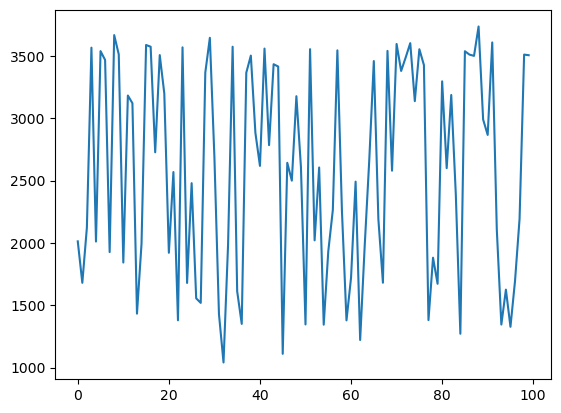

In [56]:
# LOAD_PATH = os.path.join(OUTPUT, 'baseline', 'actor.checkpoint.torch')
# eval_actor = torch.load(LOAD_PATH)

total_rewards = evaluate(eval_actor, episodes=100)
sns.lineplot(y = total_rewards, x = list(range(len(total_rewards))))
EVALUATION_PLOT_SAVE = os.path.join(OUTPUT, 'baseline', 'evaluation.png') 
plt.savefig(EVALUATION_PLOT_SAVE)
plt.show()

In [68]:
evaluate(eval_actor, episodes=1, render_human=True )

Exception ignored in: <function WindowViewer.__del__ at 0x158bafdc0>
Traceback (most recent call last):
  File "/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/envs/mujoco/mujoco_rendering.py", line 335, in __del__
    self.free()
  File "/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/envs/mujoco/mujoco_rendering.py", line 330, in free
    glfw.destroy_window(self.window)
  File "/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/glfw/__init__.py", line 1279, in destroy_window
    window_addr = ctypes.cast(ctypes.pointer(window),
TypeError: _type_ must have storage info


[3597.36767578125]